In [94]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [95]:
from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [96]:
path = '/Users/user/Desktop/floodDetection'

In [97]:
path_labels = path+'/labels'
path_images = path+'/'+'images'

In [98]:
filenames = get_image_files(path_images)
filenames[:10]

[PosixPath('/Users/user/Desktop/floodDetection/images/Label_62.png'),
 PosixPath('/Users/user/Desktop/floodDetection/images/Label_63.png'),
 PosixPath('/Users/user/Desktop/floodDetection/images/Label_49.png'),
 PosixPath('/Users/user/Desktop/floodDetection/images/Label_61.png'),
 PosixPath('/Users/user/Desktop/floodDetection/images/Label_60.png'),
 PosixPath('/Users/user/Desktop/floodDetection/images/Label_48.png'),
 PosixPath('/Users/user/Desktop/floodDetection/images/Label_64.png'),
 PosixPath('/Users/user/Desktop/floodDetection/images/Label_58.png'),
 PosixPath('/Users/user/Desktop/floodDetection/images/Label_59.png'),
 PosixPath('/Users/user/Desktop/floodDetection/images/Label_65.png')]

In [99]:
label_names = get_image_files(path_labels)
label_names[:10]

[PosixPath('/Users/user/Desktop/floodDetection/labels/Label_39_P.png'),
 PosixPath('/Users/user/Desktop/floodDetection/labels/Label_41_P.png'),
 PosixPath('/Users/user/Desktop/floodDetection/labels/Label_65_P.png'),
 PosixPath('/Users/user/Desktop/floodDetection/labels/Label_20_P.png'),
 PosixPath('/Users/user/Desktop/floodDetection/labels/Label_8_P.png'),
 PosixPath('/Users/user/Desktop/floodDetection/labels/Label_58_P.png'),
 PosixPath('/Users/user/Desktop/floodDetection/labels/Label_22_P.png'),
 PosixPath('/Users/user/Desktop/floodDetection/labels/Label_43_P.png'),
 PosixPath('/Users/user/Desktop/floodDetection/labels/Label_47_P.png'),
 PosixPath('/Users/user/Desktop/floodDetection/labels/Label_63_P.png')]

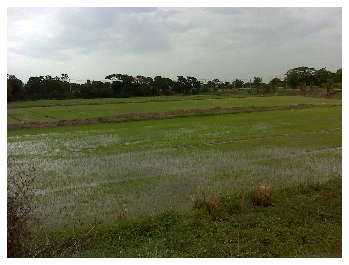

In [100]:
image_file = filenames[21]
image = open_image(image_file)
image.show(figsize=(6,6))

In [101]:
get_y_fn = lambda x: path_labels+"/"+ f'{x.stem}_P{x.suffix}'

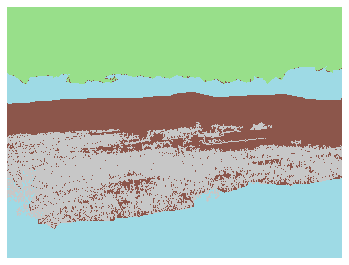

In [102]:
mask = open_mask(get_y_fn(image_file))
mask.show(figsize=(6,6), alpha=1)

In [103]:
source_size = np.array(mask.shape[1:])
source_size, mask.data

(array([720, 960]),
 tensor([[[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [4, 4, 4,  ..., 4, 4, 4],
          [4, 4, 4,  ..., 4, 4, 4],
          [4, 4, 4,  ..., 4, 4, 4]]]))

In [104]:
codes = np.loadtxt('code.txt', dtype=str)
len(codes), codes

(4, array(['sky', 'rice', 'water', 'backg'], dtype='<U5'))

In [105]:
size = source_size//2
bs = 0

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 16000: bs=16    
elif free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 0MB of GPU RAM free


In [118]:
segmentitemlist = (SegmentationItemList.from_folder(path_images)
              .split_by_rand_pct(valid_pct=0.2)
              .label_from_func(get_y_fn, classes=codes))
print(segmentitemlist)

LabelLists;

Train: LabelList (52 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /Users/user/Desktop/floodDetection/images;

Valid: LabelList (13 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /Users/user/Desktop/floodDetection/images;

Test: None


In [113]:
databunch = (segmentitemlist.transform(get_transforms(), 
                                  size=size, tfm_y=True)
             .databunch(bs=bs)
             .normalize(imagenet_stats))

Exception: It's not possible to apply those transforms to your dataset:
 Expected object of scalar type Float but got scalar type Double for argument #3 'mat2' in call to _th_addmm_out